In [2]:
# New York City Emissions Intensity Map
# by Mohamad Razkenari 
# https://www.razkenari.com/nyc-eim

In [3]:
# Install and Import packages in the current Jupyter kernel

import sys
import os

# !{sys.executable} -m pip install numpy pandas scikit-learn matplotlib seaborn arcgis sodapy folium pyspark
# !conda install --yes --prefix {sys.prefix} geopandas

import pandas as pd
import numpy as np
from sodapy import Socrata

from arcgis import GIS
from arcgis.geocoding import geocode
from arcgis.geometry import lengths, areas_and_lengths, project
from arcgis.geometry import Point, Polyline, Polygon, Geometry
import geopandas
import folium
import pickle

In [4]:
# Data ID from NYC OPEN DATA

dic_id = {
    'consumption_2020' : 'usc3-8zwd' ,  #building consumption 2020
    'consumption_2019' : 'wcm8-aq5w' , #building consumption 2019
    'consumption_2018' : '4tys-3tzj' , #building consumption 2018
    'consumption_2017' : '4tys-3tzj' , #building consumption 2017
    'consumption_2016' : 'utpj-74fz' , #building consumption 2016
    'consumption_2015' : '77q4-nkfh' , #building consumption 2015
    'consumption_2014' : 'nbun-wekj' , #building consumption 2014
    'consumption_2013' : 'yr5p-wjer' , #building consumption 2013
    'consumption_2012' : 'r6ub-zhff' , #building consumption 2012
    'consumption_2011' : 'k7nh-aufb' , #building consumption 2011
    'consumption_2010' : 'kswi-37bp' , #building consumption 2010
    'footprint' : 'qb5r-6dgf' , #building foorprint coordinates
    'points' : '7w4b-tj9d' , #building coordinates
    'pluto' : '64uk-42ks' , #Primary Land Use Tax Lot Output
    'pluto_change' : 'qt5r-nqxp' , #PLUTO changes
    }

In [5]:
"""
# RUN ONLY ONCE TO STORE THE DATA LOCALLY

socrata_domain = 'data.cityofnewyork.us'
socrata_token = os.environ.get("x52Wi0DHBQrk0WqZu2yTkQsnc")
client = Socrata(socrata_domain, socrata_token)

def store_data(df_name, api_id):
    json_data = client.get_all(api_id) # to get all data
    df = pd.DataFrame.from_dict(json_data)
    df.to_csv(df_name+'.csv')
    print(df_name+' was stored.')
    return

for key, value in dic_id.items():
    store_data(key, value)

"""

'\n# RUN ONLY ONCE TO STORE THE DATA LOCALLY\n\nsocrata_domain = \'data.cityofnewyork.us\'\nsocrata_token = os.environ.get("x52Wi0DHBQrk0WqZu2yTkQsnc")\nclient = Socrata(socrata_domain, socrata_token)\n\ndef store_data(df_name, api_id):\n    json_data = client.get_all(api_id) # to get all data\n    df = pd.DataFrame.from_dict(json_data)\n    df.to_csv(df_name+\'.csv\')\n    print(df_name+\' was stored.\')\n    return\n\nfor key, value in dic_id.items():\n    store_data(key, value)\n\n'

In [6]:
# RUN TO LOAD DATA

for key, value in dic_id.items():
    exec(f"df_{key}" + f" = pd.read_csv('{key}" + ".csv', index_col=[0], low_memory=False)")
    print('df_'+key+' was loaded.')

df_consumption_2020 was loaded.
df_consumption_2019 was loaded.
df_consumption_2018 was loaded.
df_consumption_2017 was loaded.
df_consumption_2016 was loaded.
df_consumption_2015 was loaded.
df_consumption_2014 was loaded.
df_consumption_2013 was loaded.
df_consumption_2012 was loaded.
df_consumption_2011 was loaded.
df_consumption_2010 was loaded.


C:\Users\marazken\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


df_footprint was loaded.
df_points was loaded.
df_pluto was loaded.
df_pluto_change was loaded.


In [7]:
pd.set_option("display.max_columns", None)

In [8]:
len(df_consumption_2020.nyc_borough_block_and_lot_bbl.unique())

26557

In [9]:
len(df_consumption_2020.nyc_building_identification_number_bin.unique())

26723

In [10]:
#clean consumption data

df_2020 = df_consumption_2020[['property_id', 
                               'parent_property_id', 
                               'nyc_borough_block_and_lot_bbl',
                               'nyc_building_identification_number_bin', 
                               'longitude', 
                               'latitude',
                               'address_1',
                               'city', 
                               'borough', 
                               'postcode', 
                               'census_tract', 
                               'national_median_reference_property_type',
                               'property_gfa_calculated_buildings_ft',
                               'electricity_use_grid_purchase_kwh', 
                               'natural_gas_use_kbtu', 
                               'district_steam_use_kbtu', 
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu', 
                               'electricity_use_generated_from_onsite_renewable_systems_kwh']].rename(columns={'parent_property_id':'parent_id', 
                                                                                   'nyc_borough_block_and_lot_bbl' : 'bbl',
                                                                                   'nyc_building_identification_number_bin' : 'bin', 
                                                                                   'address_1': 'address',
                                                                                   'national_median_reference_property_type': 'property_type',
                                                                                   'electricity_use_grid_purchase_kwh': 'electricity_kwh', 
                                                                                   'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                                   'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                                   'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                                   'district_steam_use_kbtu' : 'steam_kbtu' , 
                                                                                   'electricity_use_generated_from_onsite_renewable_systems_kwh' : 'onsite_renewable_kwh', 
                                                                                   'property_gfa_calculated_buildings_ft': 'floor_area_ft'})

df_2019 = df_consumption_2019[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_2020.join(df_2019.set_index('property_id'), rsuffix='_2019', on='property_id', how='left')

In [11]:
len(df_new)

29189

In [12]:
df_2018 = df_consumption_2018[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_new.join(df_2018.set_index('property_id'), rsuffix='_2018', on='property_id', how='left')

In [13]:
len(df_new)

29909

In [14]:

df_2017 = df_consumption_2017[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_new.join(df_2017.set_index('property_id'), rsuffix='_2017', on='property_id', how='left')

In [15]:
len(df_new)

31357

In [16]:
df_2016 = df_consumption_2016[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_new.join(df_2016.set_index('property_id'), rsuffix='_2016', on='property_id', how='left')

In [17]:
len(df_new)

31388

In [18]:
df_2015 = df_consumption_2015[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_new.join(df_2015.set_index('property_id'), rsuffix='_2015', on='property_id', how='left')

In [19]:
len(df_new)

31595

In [20]:
df_2014 = df_consumption_2014[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_new.join(df_2014.set_index('property_id'), rsuffix='_2014', on='property_id', how='left')

In [21]:
len(df_new)

31632

In [22]:
df_2013 = df_consumption_2013[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_new.join(df_2013.set_index('property_id'), rsuffix='_2013', on='property_id', how='left')

In [23]:
len(df_new)

31753

In [24]:
df_2012 = df_consumption_2012[['property_id',
                               'electricity_use_grid_purchase_1',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_grid_purchase_1': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_new = df_new.join(df_2012.set_index('property_id'), rsuffix='_2012', on='property_id', how='left')

In [25]:
len(df_new)

31872

In [26]:
df_2011 = df_consumption_2011[['bin_unique_building_identifier',
                               'total_floor_space_sq_ft', 
                               'electricity_use_kwh',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'bin_unique_building_identifier': 'bin', 
                                                                       'electricity_use_kwh': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_2011["bin"] = df_2011["bin"].astype('str', errors='ignore')

df_new = df_new.join(df_2011.set_index('bin'), rsuffix='_2011', on='bin', how='left')

In [27]:
len(df_new)

32167

In [28]:
df_2010 = df_consumption_2010[['bin',
                               'electricity_use_kwh',
                               'natural_gas_use_kbtu',
                               'district_steam_use_kbtu',
                               'fuel_oil_2_use_kbtu', 
                               'fuel_oil_4_use_kbtu']].rename(columns={'electricity_use_kwh': 'electricity_kwh', 
                                                                       'natural_gas_use_kbtu': 'natural_gas_kbtu', 
                                                                       'fuel_oil_2_use_kbtu': 'fuel_2_kbtu', 
                                                                       'fuel_oil_4_use_kbtu': 'fuel_4_kbtu', 
                                                                       'district_steam_use_kbtu' : 'steam_kbtu'})

df_2010["bin"] = df_2010["bin"].astype('str', errors='ignore')

df_new = df_new.join(df_2010.set_index('bin'), lsuffix='_2020', rsuffix='_2010', on='bin', how='left')

In [29]:
len(df_new)

32167

In [30]:
df_new = df_new.replace(r'Not Available', np.nan, regex=True).fillna(0)


In [37]:
df_new = df_new[df_new.longitude != 0]
df_new = df_new[df_new.latitude != 0]

In [41]:
cols = df_new.columns[12:]
df_new[cols]  = df_new[cols].apply(pd.to_numeric, errors='coerce', axis=1)

C:\Users\marazken\Anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [42]:
df_new['emissoins_2020_kgCO2_sf'] = (df_new.electricity_kwh_2020 * 0.288962 + df_new.natural_gas_kbtu_2020 * 0.05311 + 
                                     df_new.steam_kbtu_2020 * 0.04493 + df_new.fuel_2_kbtu_2020 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2020 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2019_kgCO2_sf'] = (df_new.electricity_kwh_2019 * 0.288962 + df_new.natural_gas_kbtu_2019 * 0.05311 + 
                                     df_new.steam_kbtu_2019 * 0.04493 + df_new.fuel_2_kbtu_2019 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2019 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2018_kgCO2_sf'] = (df_new.electricity_kwh_2018 * 0.288962 + df_new.natural_gas_kbtu_2018 * 0.05311 + 
                                     df_new.steam_kbtu_2018 * 0.04493 + df_new.fuel_2_kbtu_2018 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2018 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2017_kgCO2_sf'] = (df_new.electricity_kwh_2017 * 0.288962 + df_new.natural_gas_kbtu_2017 * 0.05311 + 
                                     df_new.steam_kbtu_2017 * 0.04493 + df_new.fuel_2_kbtu_2017 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2017 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2016_kgCO2_sf'] = (df_new.electricity_kwh_2016 * 0.288962 + df_new.natural_gas_kbtu_2016 * 0.05311 + 
                                     df_new.steam_kbtu_2016 * 0.04493 + df_new.fuel_2_kbtu_2016 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2016 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2015_kgCO2_sf'] = (df_new.electricity_kwh_2015 * 0.288962 + df_new.natural_gas_kbtu_2015 * 0.05311 + 
                                     df_new.steam_kbtu_2015 * 0.04493 + df_new.fuel_2_kbtu_2015 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2015 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2014_kgCO2_sf'] = (df_new.electricity_kwh_2014 * 0.288962 + df_new.natural_gas_kbtu_2014 * 0.05311 + 
                                     df_new.steam_kbtu_2014 * 0.04493 + df_new.fuel_2_kbtu_2014 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2014 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2013_kgCO2_sf'] = (df_new.electricity_kwh_2013 * 0.288962 + df_new.natural_gas_kbtu_2013 * 0.05311 + 
                                     df_new.steam_kbtu_2013 * 0.04493 + df_new.fuel_2_kbtu_2013 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2013 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2012_kgCO2_sf'] = (df_new.electricity_kwh_2012 * 0.288962 + df_new.natural_gas_kbtu_2012 * 0.05311 + 
                                     df_new.steam_kbtu_2012 * 0.04493 + df_new.fuel_2_kbtu_2012 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2012 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2011_kgCO2_sf'] = (df_new.electricity_kwh_2011 * 0.288962 + df_new.natural_gas_kbtu_2011 * 0.05311 + 
                                     df_new.steam_kbtu_2011 * 0.04493 + df_new.fuel_2_kbtu_2011 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2011 * 0.07529) / df_new.floor_area_ft

df_new['emissoins_2010_kgCO2_sf'] = (df_new.electricity_kwh_2010 * 0.288962 + df_new.natural_gas_kbtu_2010 * 0.05311 + 
                                     df_new.steam_kbtu_2010 * 0.04493 + df_new.fuel_2_kbtu_2010 * 0.07421 + 
                                     df_new.fuel_4_kbtu_2010 * 0.07529) / df_new.floor_area_ft

#Assuming expected future emissions is just the max of previous years
df_new['expected_emissoins'] = df_new.iloc[:, 70:74].max(axis=1)
df_new['expected_emissoins'][df_new['expected_emissoins'] <=0] = None

C:\Users\marazken\AppData\Local\Temp/ipykernel_58788/144364140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['emissoins_2020_kgCO2_sf'] = (df_new.electricity_kwh_2020 * 0.288962 + df_new.natural_gas_kbtu_2020 * 0.05311 +
C:\Users\marazken\AppData\Local\Temp/ipykernel_58788/144364140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['emissoins_2019_kgCO2_sf'] = (df_new.electricity_kwh_2019 * 0.288962 + df_new.natural_gas_kbtu_2019 * 0.05311 +
C:\Users\marazken\AppData\Local\Temp/ipykern

In [43]:
classification_mapping = {
        'Assembly (A)': ['CBECS - Public Assembly', 'CBECS - Food Sales', 'CBECS - Social/Meeting', 'CBECS - Courthouse',
                        'CBECS - Religious Worship','CBECS - Food Service', 'CBECS - Restaurant/Cafeteria', 
                         'CBECS - Bar/Pub/Lounge', 'CBECS - Recreation'],
        'Civic (B)' : ['CBECS - Service'],
        'Labratory (B)': ['CBECS - Laboratory'], 
        'Health Care (B)': ['CBECS - Clinic/Outpatient', 'CBECS - Medical Office'],
        'Office (B)': ['CBECS - Office & Bank/Financial', 'CBECS - Bank/Financial','CBECS - College/University', 
                         'EPA - Data Center','CBECS - Library', 'CBECS - Fire Station/Police Station'], 
        'Educational (E)': ['CBECS - Education', 'CBECS - Elementary/Middle & High School', 'CBECS - Preschool'],
        'Industrial (F)': ['Industry Survey', 'AWWA - Wastewater Plant'],
        'High Hazard (H)' :['CBECS - Refrigerated Warehouse'] ,
        'Board and Care (I-1)': ['CBECS - Inpatient Healthcare', 'CBECS - Lodging'], 
        'Medical Care and Institutional (I-2)': ['ASHE Survey', 'CBECS - Outpatient Healthcare'],
        'Detention and Correctional (I-3)': [],
        'Day Care (I-4)' : [],
        'Mercantile (M)': ['CBECS - Retail Store', 'CBECS - Grocery Store/Food Market', 'CBECS - Enclosed Mall',
                          'CBECS - Retail other than Mall', 'CBECS - Strip Shopping Mall', 
                           'CBECS - Public Order and Safety','CBECS - Enclosed Mall and Strip Shopping Mall'], 
        'Hotels and Dormitories (R-1)': ['CBECS - Hotel & Motel/Inn', 'CBECS - Dormitory'],
        'Multifamily (R-2) ': ['Fannie Mae Industry Survey - Multifamily'],
        'Storage (S)': ['CBECS - Non-Refrigerated Warehouse', 'CBECS - Unrefrigerated Warehouse & Distribution Center'],
        'Utility and Miscellaneous (U)' : ['CBECS - Public Order and Safety', 'CBECS - Other']
    }

def find_class(property_type):
    for key, value in classification_mapping.items():
        if property_type in value:
            return key

df_new['building_class'] = df_new.apply (lambda row: find_class(row.property_type), axis=1)

C:\Users\marazken\AppData\Local\Temp/ipykernel_58788/1135941711.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['building_class'] = df_new.apply (lambda row: find_class(row.property_type), axis=1)


In [44]:
df_penalty = pd.DataFrame({'building_class': ['Assembly (A)', 'Civic (B)' , 'Labratory (B)', 'Health Care (B)', 
                                     'Office (B)', 'Educational (E)', 'Industrial (F)', 'High Hazard (H)', 
                                     'Board and Care (I-1)', 'Medical Care and Institutional (I-2)', 
                                     'Detention and Correctional (I-3)', 'Day Care (I-4)' , 'Mercantile (M)', 
                                     'Hotels and Dormitories (R-1)', 'Multifamily (R-2) ', 
                                     'Storage (S)', 'Utility and Miscellaneous (U)'], 
                           'e_2024_tCO2e_sf': [0.01074, 0.02381, 0.02381, 0.02381, 0.00846, 0.00758, 0.00574, 
                                              0.02381, 0.01138, 0.02381, 0.02381, 0.00758, 0.01181, 0.00987, 
                                              0.00675, 0.00426, 0.00426], 
                           'e_2030_tCO2e_sf': [0.00420 , 0.01193,  0.01193, 0.01193, 0.00453, 0.00344, 0.00167, 
                                              0.01193, 0.00598, 0.01193, 0.01193, 0.00344, 0.00403, 0.00526, 
                                              0.00407, 0.00110, 0.00110],
                           'e_2050_tCO2e_sf': 0.0014})

In [45]:
df_new = df_new.join(df_penalty.set_index('building_class'), on='building_class', how='left')

In [46]:
df_new['estimated_penalty_2024'] = (df_new.expected_emissoins/1000 - df_new.e_2024_tCO2e_sf) * 268 * df_new.floor_area_ft
df_new['estimated_penalty_2030'] = (df_new.expected_emissoins/1000 - df_new.e_2030_tCO2e_sf) * 268 * df_new.floor_area_ft
df_new['estimated_penalty_2050'] = (df_new.expected_emissoins/1000 - df_new.e_2050_tCO2e_sf) * 268 * df_new.floor_area_ft

In [47]:
import warnings

with warnings.catch_warnings(record=True):
    df_new['estimated_penalty_2024'][df_new['estimated_penalty_2024'] < 0] = 0
    df_new['estimated_penalty_2030'][df_new['estimated_penalty_2030'] < 0] = 0
    df_new['estimated_penalty_2050'][df_new['estimated_penalty_2050'] < 0] = 0

In [48]:
df_new.estimated_penalty_2024.describe()

count    2.986500e+04
mean     9.983026e+04
std      8.590821e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.573240e+03
max      1.261604e+09
Name: estimated_penalty_2024, dtype: float64

In [49]:
df_new.head()

,property_id,parent_id,bbl,bin,longitude,latitude,address,city,borough,postcode,census_tract,property_type,floor_area_ft,electricity_kwh_2020,natural_gas_kbtu_2020,steam_kbtu_2020,fuel_2_kbtu_2020,fuel_4_kbtu_2020,onsite_renewable_kwh,electricity_kwh_2019,natural_gas_kbtu_2019,steam_kbtu_2019,fuel_2_kbtu_2019,fuel_4_kbtu_2019,electricity_kwh_2018,natural_gas_kbtu_2018,steam_kbtu_2018,fuel_2_kbtu_2018,fuel_4_kbtu_2018,electricity_kwh_2017,natural_gas_kbtu_2017,steam_kbtu_2017,fuel_2_kbtu_2017,fuel_4_kbtu_2017,electricity_kwh_2016,natural_gas_kbtu_2016,steam_kbtu_2016,fuel_2_kbtu_2016,fuel_4_kbtu_2016,electricity_kwh_2015,natural_gas_kbtu_2015,steam_kbtu_2015,fuel_2_kbtu_2015,fuel_4_kbtu_2015,electricity_kwh_2014,natural_gas_kbtu_2014,steam_kbtu_2014,fuel_2_kbtu_2014,fuel_4_kbtu_2014,electricity_kwh_2013,natural_gas_kbtu_2013,steam_kbtu_2013,fuel_2_kbtu_2013,fuel_4_kbtu_2013,electricity_kwh_2012,natural_gas_kbtu_2012,steam_kbtu_2012,fuel_2_kbtu_2012,fuel_4_kbtu_2012,total_floor_space_sq_ft,electricity_kwh_2011,natural_gas_kbtu_2011,steam_kbtu_2011,fuel_2_kbtu_2011,fuel_4_kbtu_2011,electricity_kwh_2010,natural_gas_kbtu_2010,steam_kbtu_2010,fuel_2_kbtu_2010,fuel_4_kbtu_2010,emissoins_2020_kgCO2_sf,emissoins_2019_kgCO2_sf,emissoins_2018_kgCO2_sf,emissoins_2017_kgCO2_sf,emissoins_2016_kgCO2_sf,emissoins_2015_kgCO2_sf,emissoins_2014_kgCO2_sf,emissoins_2013_kgCO2_sf,emissoins_2012_kgCO2_sf,emissoins_2011_kgCO2_sf,emissoins_2010_kgCO2_sf,expected_emissoins,building_class,e_2024_tCO2e_sf,e_2030_tCO2e_sf,e_2050_tCO2e_sf,estimated_penalty_2024,estimated_penalty_2030,estimated_penalty_2050
0,7365,Not Applicable: Standalone Property,1009970029,1022631,-73.982826,40.756631,1155 Avenue of the Americas,Manhattan,MANHATTAN,10036,119.0,CBECS - Office & Bank/Financial,686838.0,6508637.9,0.0,6414034.1,0.0,0.0,0.0,7478830.4,0.0,8826445.8,0.0,0.0,7032631.5,0.0,7360193.3,0.0,0.0,7032631.5,0.0,7360193.3,0.0,0.0,43236898.1,0.0,7884370.6,0.0,0.0,42624239.4,0.0,10448889.5,0.0,0.0,35883696.9,0.0,1178826.5,0.0,0.0,43525075.6,0.0,10833326.3,0.0,0.0,12606133.4,0.00,7742025.14,0.0,0.0,686902.0,13224515.0,0.00,8773580.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.157850,3.723833,3.440195,3.440195,18.706107,18.616113,15.173869,19.020255,5.810020,6.137662,0.0,3.723833,Office (B),0.00846,0.00453,0.0014,0.000000,0.000000e+00,4.277539e+05
1,8139,Not Applicable: Standalone Property,1013150001,1037545,-73.974306,40.750698,200 East 42nd St.,Manhattan,MANHATTAN,10017,88.0,CBECS - Office & Bank/Financial,384432.0,4198817.0,0.0,75992330.6,0.0,0.0,0.0,5145089.8,0.0,19058831.0,0.0,0.0,5072947.2,0.0,21525233.0,0.0,0.0,5072947.2,0.0,21525233.0,0.0,0.0,18834997.5,0.0,18243921.1,0.0,0.0,1792352.6,0.0,19325084.3,0.0,0.0,16720703.9,0.0,16063977.2,0.0,0.0,16502793.1,0.0,18103233.1,0.0,0.0,4761252.5,0.00,15443987.89,0.0,0.0,384432.0,4978751.6,0.00,18580990.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.037588,6.094833,6.328864,6.328864,16.289742,3.605834,14.445734,14.520275,5.383838,5.913956,0.0,12.037588,Office (B),0.00846,0.00453,0.0014,368590.919486,7.734901e+05,1.095967e+06
2,8604,Not Applicable: Standalone Property,1009990019,1022667,-73.982504,40.758310,114 West 47th st,Manhattan,MANHATTAN,10036,125.0,CBECS - Office & Bank/Financial,577534.0,6117997.0,893036.7,10562069.7,0.0,0.0,0.0,7454399.3,950954.5,12554187.8,0.0,0.0,7556580.9,963227.2,13872326.2,0.0,0.0,7556580.9,963227.2,13872326.2,0.0,0.0,23575937.3,374132.2,11999922.1,0.0,0.0,22458268.5,0.0,13630241.8,0.0,0.0,24763842.2,0.0,13666849.5,0.0,0.0,24561684.6,0.0,11027204.8,0.0,0.0,8250752.9,0.00,8128745.79,0.0,0.0,572369.0,8234848.5,0.00,8427500.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.964878,4.793835,4.948636,4.948636,12.763883,12.297099,13.453513,13.147011,4.760548,4.775833,0.0,4.948636,Office (B),0.00846,0.00453,0.0014,0.000000,6.479605e+04,5.492547e+05
3,8841,Not Applicable: Standalone Property,1013190047,1037596,-73.972753,40.753074,733 Third Avenue,Manhattan,MANHATTAN,10017,90.0,CBECS - Office & Bank/Financial,390878.0,4207162.0,804271.7,12357732.6,0

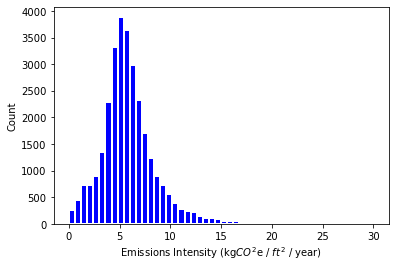

In [50]:
import matplotlib.pyplot as plt
plt.hist(df_new.expected_emissoins, bins=50 , range = (0,30), linewidth=2, edgecolor="white",color = '#0000FF')
plt.xlabel('Emissions Intensity (kg$CO^{2}$e / $ft^{2}$ / year)')
plt.ylabel('Count')
plt.savefig('emissions.png', format='png')
plt.show()

C:\Users\marazken\AppData\Local\Temp/ipykernel_58788/64998459.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,100000)


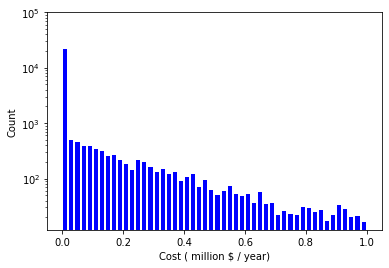

In [51]:
import matplotlib.pyplot as plt
plt.hist(df_new.estimated_penalty_2024/100000, bins=50 , range = (0,1), linewidth=2, edgecolor="white",color = '#0000FF')
plt.xlabel('Cost ( million $ / year)')
plt.ylabel('Count')
plt.yscale('log')
plt.ylim(0,100000)
plt.savefig('penalty_2024.png', format='png')
plt.show()

C:\Users\marazken\AppData\Local\Temp/ipykernel_58788/2859591664.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,100000)


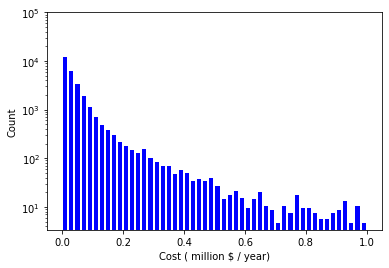

In [52]:
import matplotlib.pyplot as plt
plt.hist(df_new.estimated_penalty_2030/1000000, bins=50 , range = (0,1), linewidth=2, edgecolor="white",color = '#0000FF')
plt.xlabel('Cost ( million $ / year)')
plt.ylabel('Count')
plt.yscale('log')
plt.ylim(0,100000)
plt.savefig('penalty_2030.png', format='png')
plt.show()

C:\Users\marazken\AppData\Local\Temp/ipykernel_58788/2718322295.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,100000)


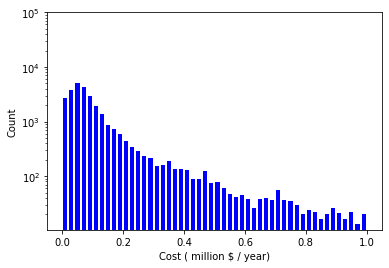

In [53]:
import matplotlib.pyplot as plt
plt.hist(df_new.estimated_penalty_2050/1000000, bins=50 , range = (0,1), linewidth=2, edgecolor="white",color = '#0000FF')
plt.xlabel('Cost ( million $ / year)')
plt.ylabel('Count')
plt.yscale('log')
plt.ylim(0,100000)
plt.savefig('penalty_2050.png', format='png')
plt.show()

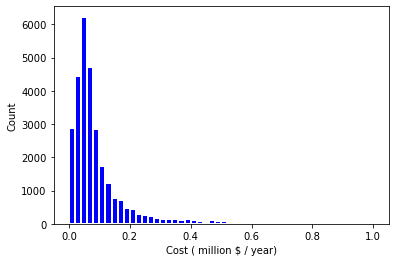

In [54]:
import matplotlib.pyplot as plt
plt.hist((df_new.estimated_penalty_2050-df_new.estimated_penalty_2024)/1000000, bins=50 , range = (0,1), linewidth=2, edgecolor="white",color = '#0000FF')
plt.xlabel('Cost ( million $ / year)')
plt.ylabel('Count')
plt.savefig('penalty_diff.png', format='png')
plt.show()

In [55]:
df_final = df_new[['bbl', 'bin', 'longitude', 'latitude', 'address', 'city', 'borough', 
                  'postcode', 'census_tract', 'building_class', 'floor_area_ft', 
                  'emissoins_2020_kgCO2_sf', 'emissoins_2019_kgCO2_sf', 'emissoins_2018_kgCO2_sf', 
                  'emissoins_2017_kgCO2_sf', 'emissoins_2016_kgCO2_sf', 'emissoins_2015_kgCO2_sf', 
                  'emissoins_2014_kgCO2_sf','emissoins_2013_kgCO2_sf', 'emissoins_2012_kgCO2_sf', 
                  'emissoins_2011_kgCO2_sf', 'emissoins_2010_kgCO2_sf','expected_emissoins', 
                  'estimated_penalty_2024', 'estimated_penalty_2030', 'estimated_penalty_2050']]

df_final.head()

,bbl,bin,longitude,latitude,address,city,borough,postcode,census_tract,building_class,floor_area_ft,emissoins_2020_kgCO2_sf,emissoins_2019_kgCO2_sf,emissoins_2018_kgCO2_sf,emissoins_2017_kgCO2_sf,emissoins_2016_kgCO2_sf,emissoins_2015_kgCO2_sf,emissoins_2014_kgCO2_sf,emissoins_2013_kgCO2_sf,emissoins_2012_kgCO2_sf,emissoins_2011_kgCO2_sf,emissoins_2010_kgCO2_sf,expected_emissoins,estimated_penalty_2024,estimated_penalty_2030,estimated_penalty_2050
0,1009970029,1022631,-73.982826,40.756631,1155 Avenue of the Americas,Manhattan,MANHATTAN,10036,119.0,Office (B),686838.0,3.157850,3.723833,3.440195,3.440195,18.706107,18.616113,15.173869,19.020255,5.810020,6.137662,0.0,3.723833,0.000000,0.000000e+00,4.277539e+05
1,1013150001,1037545,-73.974306,40.750698,200 East 42nd St.,Manhattan,MANHATTAN,10017,88.0,Office (B),384432.0,12.037588,6.094833,6.328864,6.328864,16.289742,3.605834,14.445734,14.520275,5.383838,5.913956,0.0,12.037588,368590.919486,7.734901e+05,1.095967e+06
2,1009990019,1022667,-73.982504,40.758310,114 West 47th st,Manhattan,MANHATTAN,10036,125.0,Office (B),577534.0,3.964878,4.793835,4.948636,4.948636,12.763883,12.297099,13.453513,13.147011,4.760548,4.775833,0.0,4.948636,0.000000,6.479605e+04,5.492547e+05
3,1013190047,1037596,-73.972753,40.753074,733 Third Avenue,Manhattan,MANHATTAN,10017,90.0,Office (B),390878.0,4.639959,6.433685,6.006887,6.006887,15.579725,16.042545,15.836086,16.186277,5.982637,6.551757,0.0,6.433685,0.000000,1.994211e+05,5.273052e+05
4,1009950005,1085682,-73.986244,40.756181,4 Times Square,Manhattan,MANHATTAN,10036,119.0,Office (B),1601977.0,5.721184,7.451105,7.413959,7.413959,19.722564,21.482753,24.752577,20.981639,8.467326,8.767983,0.0,7.451105,0.000000,1.254118e+06,2.597920e+06


In [56]:
df_footprint[['bin', 'the_geom', 'cnstrct_yr']].head()

,bin,the_geom,cnstrct_yr
0,3170958,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",1925.0
1,5028452,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",1965.0
2,5078368,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",1970.0
3,3245111,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",1928.0
4,4161096,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",1950.0


In [57]:
df_footprint["bin"] = df_footprint["bin"].astype('str', errors='ignore')


In [58]:
df_final = df_final.join(df_footprint[['bin', 'the_geom', 'cnstrct_yr']].set_index('bin'), on='bin', how='left')

In [59]:
len(df_final)

36974

In [60]:
df_final.to_csv('final_data.csv')

In [61]:
df_final.estimated_penalty_2030.sum()
# ', 'estimated_penalty_2030', 'estimated_penalty_2050'

4995528953.637951